In [1]:
import os
os.chdir("../../")
os.getcwd()

'/home/yeonwoo/code/study'

In [2]:
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

False

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### 기본 챗봇 구축
- `StateGraph`객체는 챗봇의 구조를 **상태 머신**으로 정의
- `nodes`는 챗봇이 호출할 수 있는 llm과 함수를 나타낸다.
- `edges`봇이 이러한 함수 간에 어떻게 전환해야 하는지 지정하기 위해 추가

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

1. `node`현재 상태를 입력으로 받고, `State`해당 상태를 업데이트 하는 것을 반환
2. `messages`현재 목록에 추가

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-2024-08-06")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

- `chatbot` 노드 기능이 현재 상태를 입력으로 사용하고 `State` 키 아래에 업데이트된 "messages" 목록이 포함된 사전을 반환하는 방식에 주목하세요.
- `State`의 `add_messages` 함수는 이미 상태에 있는 모든 메시지에 llm의 응답 메시지를 추가합니다.
- 다음으로 진입점을 추가합니다. 이는 그래프를 실행할 때마다 작업을 시작할 위치를 알려줍니다.

- 다음으로 `START` 지점을 추가합니다. 이는 그래프를 실행할 때마다 작업을 시작할 위치를 알려줍니다.

In [6]:
graph_builder.add_edge(START, "chatbot")

- 마찬가지로 `FINISH` 지점을 설정합니다. 이는 그래프에 "이 노드가 실행될 때마다 종료할 수 있습니다."라고 지시합니다.

In [7]:
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

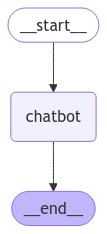

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages":[("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("끝!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "니가 LangGraph로 하려는게 뭔데?"
        print("User: "+user_input)
        stream_graph_updates(user_input)
        break
        

Assistant: 안녕하세요! 어떻게 도와드릴까요?
끝!


### Tool 사용하여 챗봇 강화

In [11]:
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.tools.google_search import GoogleSearchResults
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import Tool

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

tool = TavilySearchResults(max_results=2)
tools = [tool]

# os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
# os.environ["GOOGLE_CSE_ID"] = os.getenv("GOOGLE_CSE_ID")
# k=2
# search = GoogleSearchAPIWrapper(k=10)
# tool = GoogleSearchResults(num_results=k,api_wrapper=search)

# def topK_results(query):
#     return search.results(query, k)


# tool = Tool(
#     name="Google Search Snippets",
#     description="Search Google for recent results.",
#     func=topK_results
# )

In [12]:
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

In [13]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-2024-08-06")

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

- 아래에서는 상태의 가장 최근 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode를 구현합니다. LLM의 tool_calling 지원에 의존합니다.
- 나중에 이를 LangGraph의 사전 구축된 ToolNode로 대체하여 작업 속도를 높일 예정이지만 먼저 직접 구축하는 것이 유익합니다.

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [15]:
from typing import Literal

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

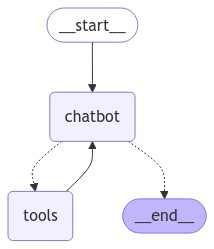

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


### memory to the chatbot

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


인메모리 체크포인터를 사용하고 있다는 점에 주목하세요. 이는 튜토리얼에 편리합니다(모든 내용을 메모리에 저장합니다). 프로덕션 애플리케이션에서는 SqliteSaver 또는 PostgresSaver를 사용하고 자신의 DB에 연결하도록 이를 변경할 수 있습니다.

다음으로 그래프를 정의합니다. 이제 자신만의 BasicToolNode를 이미 구축했으므로 이를 LangGraph의 사전 구축된 ToolNode 및 tools_condition으로 대체하겠습니다. 이는 병렬 API 실행과 같은 몇 가지 유용한 작업을 수행하기 때문입니다.

In [19]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [20]:
graph = graph_builder.compile(checkpointer=memory)

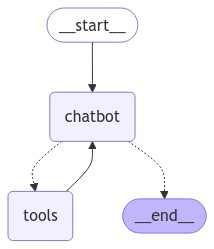

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [23]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [24]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Your name is Will. How can I assist you further?


In [25]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal data like names across interactions. However, I'm here to help with any questions or information you need!


In [26]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='5f57ac0c-c45a-48c8-b512-70e56947e702'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-8e51fdb1-e2fc-4413-b12b-db8889b43913-0', usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, res

In [27]:
snapshot.next

()

### Human-in-the-loop
에이전트는 신뢰할 수 없으며 작업을 성공적으로 수행하려면 사람의 입력이 필요할 수 있습니다. 마찬가지로 일부 작업의 경우 모든 것이 의도한 대로 실행되는지 확인하기 위해 실행하기 전에 사람의 승인을 요구할 수 있습니다.

LangGraph는 다양한 방법으로 인간 참여형(Human-In-The-Loop) 워크플로를 지원합니다. 이 섹션에서는 LangGraph의 Interrupt_before 기능을 사용하여 항상 도구 노드를 중단합니다.

In [28]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [29]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=['tools'],
)

In [30]:
user_input = "나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘
================================== Ai Message ==================================

LangGraph에 대해 알려드릴게요. LangGraph는 언어 모델을 사용하여 그래프 기반의 데이터를 처리하거나 시각화하는 도구입니다. 주로 자연어 처리(NLP)와 관련된 작업에 유용하게 사용될 수 있습니다. LangGraph를 사용하는 방법은 다음과 같습니다:

1. **설치 및 설정**:
   - LangGraph를 사용하기 위해서는 먼저 해당 패키지를 설치해야 합니다. 보통 Python 환경에서 `pip` 명령어를 사용하여 설치할 수 있습니다.
   - 예: `pip install langgraph`

2. **데이터 준비**:
   - 그래프 형태로 변환할 데이터를 준비합니다. 예를 들어, 텍스트 데이터나 관계 데이터 등을 사용할 수 있습니다.

3. **그래프 생성**:
   - LangGraph를 사용하여 데이터를 그래프 형태로 변환합니다. 이 과정에서는 노드와 엣지를 정의하고, 각 요소 간의 관계를 설정하게 됩니다.

4. **분석 및 시각화**:
   - 생성된 그래프를 분석하거나 시각화하여 데이터의 패턴이나 구조를 이해할 수 있습니다.
   - LangGraph는 다양한 시각화 기능을 제공하여 그래프를 쉽게 탐색할 수 있도록 도와줍니다.

5. **응용**:
   - LangGraph를 활용하여 텍스트 분석, 정보 검색, 지식 그래프 구축 등 다양한 응용 분야에 적용할 수 있습니다.

LangGraph의 사용 방법은 프로젝트의 목표나 데이터의 특성에 따라 달라질 수 있으니, 공식 문서나 튜토리얼을 참조하여 더 자세한 정보를 얻는 것이 좋습니다. 도움이 필요하면 언제

In [31]:
snapshot = graph.get_state(config)
snapshot.next

()

In [32]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[]

In [33]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

LangGraph에 대해 알려드릴게요. LangGraph는 언어 모델을 사용하여 그래프 기반의 데이터를 처리하거나 시각화하는 도구입니다. 주로 자연어 처리(NLP)와 관련된 작업에 유용하게 사용될 수 있습니다. LangGraph를 사용하는 방법은 다음과 같습니다:

1. **설치 및 설정**:
   - LangGraph를 사용하기 위해서는 먼저 해당 패키지를 설치해야 합니다. 보통 Python 환경에서 `pip` 명령어를 사용하여 설치할 수 있습니다.
   - 예: `pip install langgraph`

2. **데이터 준비**:
   - 그래프 형태로 변환할 데이터를 준비합니다. 예를 들어, 텍스트 데이터나 관계 데이터 등을 사용할 수 있습니다.

3. **그래프 생성**:
   - LangGraph를 사용하여 데이터를 그래프 형태로 변환합니다. 이 과정에서는 노드와 엣지를 정의하고, 각 요소 간의 관계를 설정하게 됩니다.

4. **분석 및 시각화**:
   - 생성된 그래프를 분석하거나 시각화하여 데이터의 패턴이나 구조를 이해할 수 있습니다.
   - LangGraph는 다양한 시각화 기능을 제공하여 그래프를 쉽게 탐색할 수 있도록 도와줍니다.

5. **응용**:
   - LangGraph를 활용하여 텍스트 분석, 정보 검색, 지식 그래프 구축 등 다양한 응용 분야에 적용할 수 있습니다.

LangGraph의 사용 방법은 프로젝트의 목표나 데이터의 특성에 따라 달라질 수 있으니, 공식 문서나 튜토리얼을 참조하여 더 자세한 정보를 얻는 것이 좋습니다. 도움이 필요하면 언제든지 말씀해 주세요!


### Manually Updating the State
이전 섹션에서는 인간이 그래프의 동작을 검사할 수 있도록 그래프를 중단하는 방법을 보여주었습니다. 이를 통해 인간은 상태를 읽을 수 있지만 에이전트의 과정을 변경하려면 쓰기 액세스 권한이 필요합니다.

다행히도 LangGraph에서는 상태를 수동으로 업데이트할 수 있습니다! 상태를 업데이트하면 해당 작업을 수정하여 에이전트의 궤적을 제어할 수 있습니다(과거 수정도 가능). 이 기능은 상담원의 실수를 수정하거나, 대체 경로를 탐색하거나, 상담원을 특정 목표로 안내하려는 경우에 특히 유용합니다.

아래에서는 체크포인트 상태를 업데이트하는 방법을 보여드리겠습니다. 이전과 마찬가지로 먼저 그래프를 정의합니다. 이전과 똑같은 그래프를 재사용하겠습니다.

In [34]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [35]:
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=['tools']
)

user_input = "나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [36]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_fmunNVen1JXmgl6fCtOTUcWH)
 Call ID: call_fmunNVen1JXmgl6fCtOTUcWH
  Args:
    query: langgraph 사용법


In [37]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='e15abaa4-4250-4b0c-932c-8f5a62f5393f', tool_call_id='call_fmunNVen1JXmgl6fCtOTUcWH'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='4cc7708d-f4c8-48d9-aac7-7070a3e9d351')]


In [38]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [39]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9e9fc-fc0e-6770-8003-26b84dbbaf14'}}

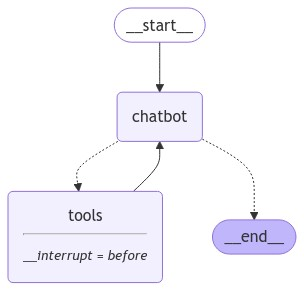

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='e15abaa4-4250-4b0c-932c-8f5a62f5393f', tool_call_id='call_fmunNVen1JXmgl6fCtOTUcWH'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='4cc7708d-f4c8-48d9-aac7-7070a3e9d351'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='6e12bfd2-b783-4387-a39a-ebf4ae8624cc')]
()


In [42]:
user_input = "나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘"
config = {"configurable": {"thread_id": "2"}}
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0wvSv3sNhZYu3C65G1gn9G2A)
 Call ID: call_0wvSv3sNhZYu3C65G1gn9G2A
  Args:
    query: langgraph 사용법


In [43]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-d1e7626a-f78e-438c-8008-615a90d2854d-0
{'name': 'tavily_search_results_json', 'args': {'query': 'langgraph 사용법'}, 'id': 'call_0wvSv3sNhZYu3C65G1gn9G2A', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_0wvSv3sNhZYu3C65G1gn9G2A', 'type': 'tool_call'}
Message ID run-d1e7626a-f78e-438c-8008-615a90d2854d-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_0wvSv3sNhZYu3C65G1gn9G2A',
  'type': 'tool_call'}]

In [44]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0wvSv3sNhZYu3C65G1gn9G2A)
 Call ID: call_0wvSv3sNhZYu3C65G1gn9G2A
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://medium.com/@kbdhunga/implementing-human-in-the-loop-with-langgraph-ccfde023385c", "content": "Implementing a Human-in-the-Loop (HIL) framework in LangGraph with the Streamlit app provides a robust mechanism for user engagement and decision-making. By incorporating breakpoints and"}]
================================== Ai Message ==================================

LangGraph를 사용하여 Human-i

### Customizing State

In [69]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

from pydantic import BaseModel

class RequestAssistance(BaseModel):
    request: str

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [70]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [71]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [72]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

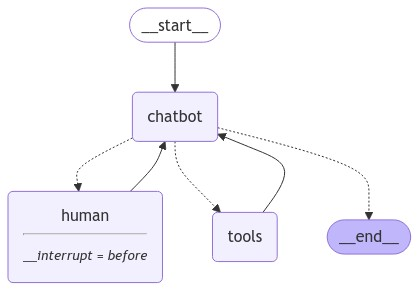

In [73]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [74]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_RvpGUnanskxQKm09zUYqEJMc)
 Call ID: call_RvpGUnanskxQKm09zUYqEJMc
  Args:
    request: I am looking for expert guidance on building an AI agent. Can you provide some resources or connect me with an expert in the field?


In [75]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [76]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9ea19-abe4-6eff-8002-e6adcf7b9ac7'}}

In [77]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='387735e0-985e-4e3d-a3b3-641bc7e52cde'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RvpGUnanskxQKm09zUYqEJMc', 'function': {'arguments': '{"request":"I am looking for expert guidance on building an AI agent. Can you provide some resources or connect me with an expert in the field?"}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 112, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0f3f86b-87

In [78]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent, as it is more reliable and extensible compared to simpler autonomous agents. If you need more detailed guidance or resources, please let me know!


### Time Travel

In [79]:
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [80]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [81]:
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [82]:
graph_builder.add_node("human", human_node)

In [83]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

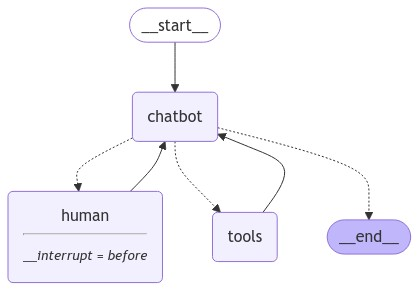

In [84]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [85]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

나는 langgraph를 공부하고 싶다. langgraph를 사용하는 방법에 대해서 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7YKPL74SVmxaQ3mRBT4EAp81)
 Call ID: call_7YKPL74SVmxaQ3mRBT4EAp81
  Args:
    query: langgraph 사용 방법
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://velog.io/@euisuk-chung/강의-LangChain-Academy-Introduction-to-LangGraph", "content": "Tools (도구): 각 노드가 외부 도구를 호출하고 상태를 수정할 수 있는 기능을 의미합니다. LangGraph에서는 리듀서 함수(예: add_messages)를 사용하여 상태를 덮어쓰는 대신 새로운 데이터를 기존 상태에 추가할 수 있도록 만듭니다. return {\"messages\": [llm_with_tools.invoke(state[\"messages\"])]} new_message = llm_with_tools.invoke(state[\"messages\"]) return {\"messages\": [llm_with_tools.invoke(state[\"messages\"])]} 이 방식은 여러 번의 도구 호출을 필요로 하는 복잡한 작업을 처리할 수 있으며, LLM이 결과를 기반으로 추가 작업을 수행할 수 있는 유연성을 제공합니다. 

In [86]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can leverage its capabilities in managing complex workflows and interactions between multiple AI systems. If you have any more questions or need further assistance as you work on your project, feel free to ask. Good luck with your development!


In [87]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [88]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef9ea23-4b24-647d-8006-12c45ec6a4ee'}}


In [89]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can leverage its capabilities in managing complex workflows and interactions between multiple AI systems. If you have any more questions or need further assistance as you work on your project, feel free to ask. Good luck with your development!
